### Data description

- CMPLNT_NUM -> unique number of every reported crime 
- police_precincts -> 77 police precincts, podzielone na dzielnice (https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page)
- district -> name of a discrict where crime was commited
- crime_date -> date of the crime
- crime_time -> time of the crime
- case_solved -> tag whether a given case was solved 
- housing_dev_name -> column shows whether particular crime is connected with a person living in a housing development 
- id_housing_dev -> id housing development
- ofns_level -> Level of offense: felony, misdemeanor, violation
- loc_of_occur_desc -> specific location of occurrence in or around the premises; inside, opposite of, front of, rear of (connected with prem_typ_desc)
- ofns_desc -> type of a crime 
- parks_nm -> accurate name of a place where a crime was commited
- detail_ofns_desc -> detailed type of a crime 
- prem_typ_desc -> detailed description of a place where crime was commited (connected with loc_of_occur_desc)
- notification_date -> date when the crime was reported 
- notification_station_name -> police station where the crime was reported
- susp_age_group -> suspect age group 
- susp_race -> suspect race 
- susp_sex -> suspect sex 
- vic_age_group -> victim age group 
- vic_race -> victim race 
- vic_sex -> victim sex, Victim’s Sex Description (D=Business/Organization, E=PSNY/People of the State of New York, F=Female, M=Male)
- latitude 
- longitude
- lat_lon
- district population

##### Aim of the project is to find patterns in data which will help NY police to optimize their efforts

### TO DO (POMYSŁY):
- nan przy danych przestępcy mogą być same w sobie informacja, warto sprwawdzić przy jaki przestępstwach wsytępują 
- czy w cieplejszyche misiacach wicej drobnych kradziży w stosunku do reszty? - napływ turystów do NY
- potrzebuje danych o ludności dzielnic aby przeliczyc dane w przestępstwach na osobe 
- jakie rodzaje przestępstw sa najcześciej nierozwiazywalne
- dorobić kolummny  time_span from crime to report

### Analiza pomysły:
- wstępna wizualizacja: 
                        - vic i susp na kołowych
                        - geopandas (całość i z filtrem na konkretne dzielnice)
                        - jaki komisariat najwiecej zgłoszeń 
- jakie grupy wiekowe/rasy/płcie najczesniej jakie przestępstwa popełniają czy podopne itp
- jakie przestępstwa ludzie  z housing dev 
- w jakiej dzielnicy jakich przestępstw najwięcej jako % w ilości przestępstw 
- ile czasu od wydarzenia do zgłoszenia i podtem podział na rodzaje, jakie przestępstwa zgłaszano najpóźniej itp histogram opóźnienia
- parks_nm użyć do znalezienia najbardziej nie bezpiecznych miejsc
- jakie rodzaje przestępstw w jakich miejscach i kogo dotyczyły, kto musi uważać i gdzie (system ostrzeżeń przed najbardziej uciążliwymi przestępswami) 

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
pd.set_option('display.max_columns',30)

## Loading and cleaning data

In [81]:
df = pd.read_excel("data.xlsx", index_col='CMPLNT_NUM')

,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,...,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
CMPLNT_NUM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
314773184,48,BRONX,12/31/2019,18:00:00,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,105,FELONY,NaN,ROBBERY,...,STREET,12/31/2019,NaN,UNKNOWN,UNKNOWN,U,NaN,45-64,WHITE HISPANIC,F,1016990,244612,40.838026,-73.881681,"(40.838026269000075, -73.88168118799997)"
289837961,25,MANHATTAN,12/30/2019,20:30:00,12/31/2019,10:00:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,...,RESIDENCE - APT. HOUSE,12/31/2019,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,F,999296,230862,40.800334,-73.945657,"(40.800334261000046, -73.94565697199994)"
535744284,77,BROOKLYN,12/24/2019,16:55:00,12/24/2019,17:00:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,106,FELONY,NaN,FELONY ASSAULT,...,STREET,12/31/2019,NaN,UNKNOWN,BLACK,M,NaN,18-24,WHITE,M,1001068,183317,40.669832,-73.939376,"(40.66983179600004, -73.93937555099996)"
895678119,52,BRONX,12/30/2019,19:32:00,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,...,CHAIN STORE,12/30/2019,NaN,25-44,WHITE,F,NaN,UNKNOWN,UNKNOWN,D,1009690,257590,40.873671,-73.908014,"(40.87367103500002, -73.90801364899994)"
299841674,18,MANHATTAN,12/30/2019,15:30:00,12/30/2019,16:50:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,NaN,PETIT LARCENY,...,STREET,12/30/2019,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,M,985766,216503,40.760935,-73.994529,"(40.76093528000007, -73.99452906599998)"


In [82]:
#cleaning data and preparing it for analysis
columns=['JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', 'PATROL_BORO', 'PD_CD', 'TRANSIT_DISTRICT', 
         'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'X_COORD_CD', 'Y_COORD_CD']

to_del_susp_age_group = [-965,-966, -964, -973, -968, -64, 930, -1, -80, 947, 929, 1019, 940, 2019, 924]
to_del_vic_age_group = [-961, -952, 936, -71, -943, 956, -50, 941, -942, -39, 1013, -69, -67, 937, -946, -974, 951, 960, 
                        927, -2,938, -934, -978, -970, -56, -954, 943, 929, -967, 1018, -948]

#deleting columns
df.drop(columns=columns, inplace=True)

#changing values for boolean
df['CRM_ATPT_CPTD_CD'].replace({'COMPLETED':1, 'ATTEMPTED':0}, inplace=True)

#deleting wrong values from susp_age_group and vic_age_group columns

for x in to_del_susp_age_group:
    filt = df['SUSP_AGE_GROUP'] == x
    df.drop(index = df[filt].index, inplace=True)
    
for x in to_del_vic_age_group:
    filt = df['VIC_AGE_GROUP'] == x
    df.drop(index = df[filt].index, inplace=True)

#usunięcie wartości Nan z boro_nm i ofns_desc
df = df[~df['BORO_NM'].isnull()]
df = df[~df['VIC_AGE_GROUP'].isnull()]
df.dropna(how='any', subset=['OFNS_DESC', 'PREM_TYP_DESC'], inplace=True)

#changin and unifying values
df["SUSP_AGE_GROUP"].replace( np.nan, 'UNKNOWN', inplace=True)
df['SUSP_RACE'].replace(np.nan, 'UNKNOWN', inplace=True)
df['SUSP_SEX'].replace('U', 'UNKNOWN', inplace=True)

#changing type of data of columns with dates
date_columns = ['CMPLNT_FR_DT', 'RPT_DT']

for x in date_columns:
    df[x] = df[x].map(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))
    df[x] = df[x].map(lambda x: x.date())

df['crime_day'] = df['CMPLNT_FR_DT'].map(lambda x: x.isoweekday())
df['crime_month'] = df['CMPLNT_FR_DT'].map(lambda x: x.month)
#df['time_span'] = pd.to_datetime(df['notification_date']) - pd.to_datetime(df['crime_day'])
    
df.columns = [x.lower() for x in df.columns]

In [84]:
#changing columns names for simpler and more unambiguous and reordering them
df.rename(columns={"cmplnt_num":'case_id', 'addr_pct_cd':'police_precincts', 'boro_nm':'district', 
                   'cmplnt_fr_dt':'crime_date', 'cmplnt_fr_tm':'crime_time','cmplnt_to_dt':'end_crime_date', 
                   'cmplnt_to_tm':'end_crime_time', 'crm_atpt_cptd_cd':'case_solved', 'hadevelopt': 'housing_dev_name',
                   'housing_psa':'id_housing_dev','law_cat_cd': 'ofns_level',
                   'pd_desc': 'detail_ofns_desc', 'rpt_dt': 'notification_date', 
                   'station_name':'notification_station_name'}, inplace=True)

In [86]:
#NY population by Borough
ny_population = {
    'district': ['Total', 'BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'],
    'population': [8550971, 1446788, 2648452, 1638281, 2330295, 487155]
}
ny_population = pd.DataFrame(ny_population)

        district  population
0          Total     8550971
1          BRONX     1446788
2       BROOKLYN     2648452
3      MANHATTAN     1638281
4         QUEENS     2330295
5  STATEN ISLAND      487155


## Initial exploration and further data preparation

In [87]:
#adding new column with population depending on distric
df = df.merge(ny_population, on='district', how='left')

,police_precincts,district,crime_date,crime_time,case_solved,housing_dev_name,id_housing_dev,ofns_level,loc_of_occur_desc,ofns_desc,parks_nm,detail_ofns_desc,prem_typ_desc,notification_date,notification_station_name,susp_age_group,susp_race,susp_sex,vic_age_group,vic_race,vic_sex,latitude,longitude,lat_lon,crime_day,crime_month,population
1,48,BRONX,2019-12-31,18:00:00,1,NaN,NaN,FELONY,NaN,ROBBERY,NaN,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,2019-12-31,NaN,UNKNOWN,UNKNOWN,UNKNOWN,45-64,WHITE HISPANIC,F,40.838026,-73.881681,"(40.838026269000075, -73.88168118799997)",2,12,1446788
3,25,MANHATTAN,2019-12-30,20:30:00,1,NaN,NaN,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,2019-12-31,NaN,UNKNOWN,UNKNOWN,NaN,25-44,WHITE HISPANIC,F,40.800334,-73.945657,"(40.800334261000046, -73.94565697199994)",1,12,1638281
2,77,BROOKLYN,2019-12-24,16:55:00,1,NaN,NaN,FELONY,NaN,FELONY ASSAULT,NaN,"ASSAULT 2,1,UNCLASSIFIED",STREET,2019-12-31,NaN,UNKNOWN,BLACK,M,18-24,WHITE,M,40.669832,-73.939376,"(40.66983179600004, -73.93937555099996)",2,12,2648452
1,52,BRONX,2019-12-30,19:32:00,1,NaN,NaN,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,"LARCENY,PETIT FROM STORE-SHOPL",CHAIN STORE,2019-12-30,NaN,25-44,WHITE,F,UNKNOWN,UNKNOWN,D,40.873671,-73.908014,"(40.87367103500002, -73.90801364899994)",1,12,1446788
3,18,MANHATTAN,2019-12-30,15:30:00,1,NaN,NaN,MISDEMEANOR,NaN,PETIT LARCENY,NaN,"LARCENY,PETIT BY ACQUIRING LOS",STREET,2019-12-30,NaN,UNKNOWN,UNKNOWN,NaN,25-44,WHITE HISPANIC,M,40.760935,-73.994529,"(40.76093528000007, -73.99452906599998)",1,12,1638281


In [88]:
df.rename(columns={'population':'disctrict_population'})

,police_precincts,district,crime_date,crime_time,case_solved,housing_dev_name,id_housing_dev,ofns_level,loc_of_occur_desc,ofns_desc,parks_nm,detail_ofns_desc,prem_typ_desc,notification_date,notification_station_name,susp_age_group,susp_race,susp_sex,vic_age_group,vic_race,vic_sex,latitude,longitude,lat_lon,crime_day,crime_month,disctrict_population
1,48,BRONX,2019-12-31,18:00:00,1,NaN,NaN,FELONY,NaN,ROBBERY,NaN,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,2019-12-31,NaN,UNKNOWN,UNKNOWN,UNKNOWN,45-64,WHITE HISPANIC,F,40.838026,-73.881681,"(40.838026269000075, -73.88168118799997)",2,12,1446788
3,25,MANHATTAN,2019-12-30,20:30:00,1,NaN,NaN,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,2019-12-31,NaN,UNKNOWN,UNKNOWN,NaN,25-44,WHITE HISPANIC,F,40.800334,-73.945657,"(40.800334261000046, -73.94565697199994)",1,12,1638281
2,77,BROOKLYN,2019-12-24,16:55:00,1,NaN,NaN,FELONY,NaN,FELONY ASSAULT,NaN,"ASSAULT 2,1,UNCLASSIFIED",STREET,2019-12-31,NaN,UNKNOWN,BLACK,M,18-24,WHITE,M,40.669832,-73.939376,"(40.66983179600004, -73.93937555099996)",2,12,2648452
1,52,BRONX,2019-12-30,19:32:00,1,NaN,NaN,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,"LARCENY,PETIT FROM STORE-SHOPL",CHAIN STORE,2019-12-30,NaN,25-44,WHITE,F,UNKNOWN,UNKNOWN,D,40.873671,-73.908014,"(40.87367103500002, -73.90801364899994)",1,12,1446788
3,18,MANHATTAN,2019-12-30,15:30:00,1,NaN,NaN,MISDEMEANOR,NaN,PETIT LARCENY,NaN,"LARCENY,PETIT BY ACQUIRING LOS",STREET,2019-12-30,NaN,UNKNOWN,UNKNOWN,NaN,25-44,WHITE HISPANIC,M,40.760935,-73.994529,"(40.76093528000007, -73.99452906599998)",1,12,1638281
2,94,BROOKLYN,2019-12-28,13:00:00,1,NaN,NaN,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,"LARCENY,PETIT OF LICENSE PLATE",STREET,2019-12-30,NaN,UNKNOWN,UNKNOWN,NaN,UNKNOWN,UNKNOWN,D,40.731281,-73.950519,"(40.73128148300003, -73.95051933399996)",6,12,2648452
2,69,BROOKLYN,2019-12-22,16:30:00,1,NaN,NaN,MISDEMEANOR,FRONT OF,ASSAULT 3 & RELATED OFFENSES,NaN,ASSAULT 3,STREET,2019-12-30,NaN,25-44,BLACK,M,25-44,BLACK,M,40.629159,-73.905299,"(40.629158526000026, -73.90529923099997)",7,12,2648452
1,43,BRONX,2019-12-29,17:20:00,1,NaN,NaN,FELONY,FRONT OF,ROBBERY,NaN,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,2019-12-29,NaN,UNKNOWN,WHITE HISPANIC,M,25-44,BLACK,M,40.830641,-73.874879,"(40.83064129700006, -73.87487918899996)",7,12,1446788
3,18,MANHATTAN,2019-12-29,12:30:00,1,NaN,NaN,MISDEMEANOR,NaN,SEX CRIMES,NaN,"SEXUAL ABUSE 3,2",STREET,2019-12-29,NaN,UNKNOWN,WHITE,M,25-44,WHITE,F,40.764818,-73.985190,"(40.764818269000045, -73.98518977299993)",7,12,1638281
3,13,MANHATTAN,2019-12-28,15:05:00,1,NaN,NaN,VIOLATION,INSIDE,HARRASSMENT 2,NaN,"HARASSMENT,SUBD 1,CIVILIAN",RESIDENCE - APT. HOUSE,2019-12-28,NaN,65+,WHITE,F,18-24,ASIAN / PACIFIC ISLANDER,F,40.743512,-73.994227,"(40.74351160900005, -73.99422735499998)",6,12,1638281


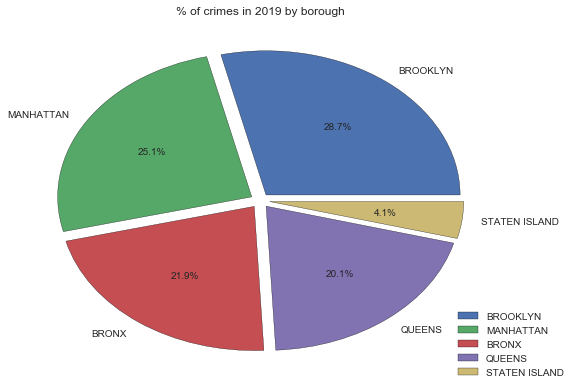

In [90]:
# %crimes by districts 
plt.style.use('seaborn')

pie_data = df['district'].value_counts(normalize=True)
explode = [0.05, 0.05, 0.05, 0.05, 0.05]
labels = df['district'].value_counts(normalize=True).index

plt.pie(pie_data, labels=labels, explode=explode, autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'})

plt.title('% of crimes in 2019 by borough')
plt.legend(loc=(0.9,0))

plt.tight_layout() 

In [107]:
# number of crimes per 100 citizens of a district

data_crimes_population = df['district'].value_counts()
data_crimes_population.merge(ny_population, on='district', how='left')

SyntaxError: invalid syntax (<ipython-input-107-32171fbdcc6d>, line 3)

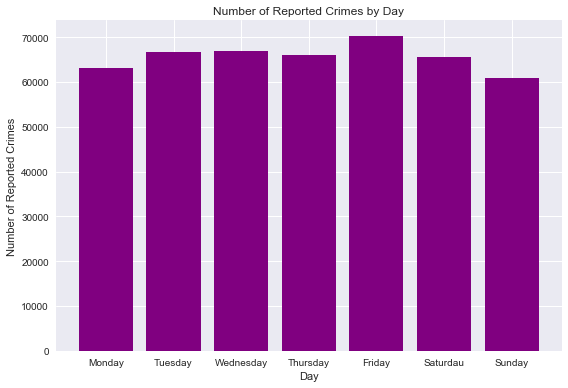

In [91]:
#number of crimes by day bar plot
bar_days = df['crime_day'].value_counts().sort_index()
ticks=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturdau', 'Sunday']
num = list(range(1,8))


plt.bar(bar_days.index, bar_days, color='purple')

plt.xticks(num, ticks)

plt.title('Number of Reported Crimes by Day')
plt.xlabel('Day')
plt.ylabel("Number of Reported Crimes")

plt.tight_layout() 

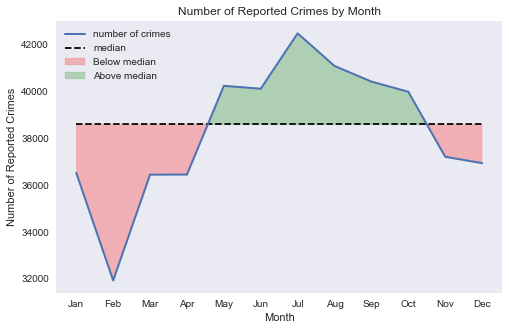

In [92]:
#number of crimes by month - line plot
ticks=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
num = list(range(1,13))
plt.figure(figsize=(8, 5))

crimes_month = df['crime_month'].value_counts().sort_index()
median = crimes_month.median()

plt.plot(crimes_month.index, crimes_month, label='number of crimes', linewidth=2)
plt.hlines(median, 1, 12, linestyle='--', label='median')

plt.title('Number of Reported Crimes by Month')
plt.xlabel('Month')
plt.ylabel("Number of Reported Crimes")
plt.xticks(num, ticks)

plt.fill_between(crimes_month.index, crimes_month,
                median, where=(median>crimes_month),
                interpolate=True,
                alpha=0.25,
                color='red',
                label='Below median'
                )

plt.fill_between(crimes_month.index, crimes_month,
                median, where=(median<=crimes_month),
                interpolate=True,
                alpha=0.25,
                color='green',
                label='Above median'
                )

plt.legend()
plt.grid(0)
#plt.plot(crimes_month.index, crimes_month)

In [93]:
#przestepstwa na dzielnice
df.columns
#df['case_solved'].value_counts()

Index(['police_precincts', 'district', 'crime_date', 'crime_time',
       'case_solved', 'housing_dev_name', 'id_housing_dev', 'ofns_level',
       'loc_of_occur_desc', 'ofns_desc', 'parks_nm', 'detail_ofns_desc',
       'prem_typ_desc', 'notification_date', 'notification_station_name',
       'susp_age_group', 'susp_race', 'susp_sex', 'vic_age_group', 'vic_race',
       'vic_sex', 'latitude', 'longitude', 'lat_lon', 'crime_day',
       'crime_month', 'population'],
      dtype='object')

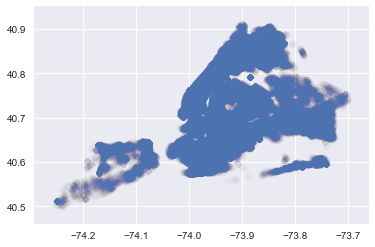

In [94]:
#mapa przestęspstw, DO DOKOŃCZENIA PO ZAINSTALOWANIU GEOPANDAS
%matplotlib qt
plt.figure(figsize=(12, 8))
lon = df['latitude']
lat = df['longitude']

%matplotlib inline

plt.scatter(lat, lon, alpha=0.005)

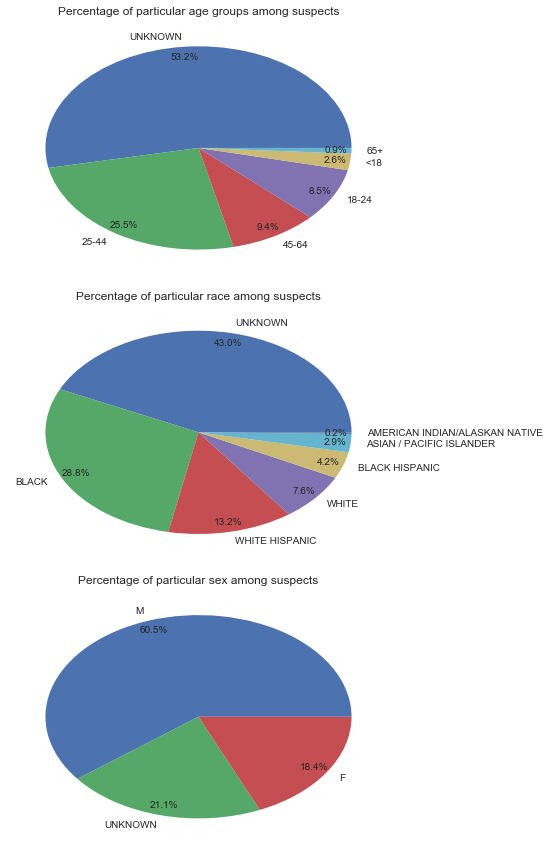

In [95]:
#susp pie plots
%matplotlib inline

data_susp_1 = df['susp_age_group'].value_counts(normalize=True)
data_susp_2 = df['susp_race'].value_counts(normalize=True)
data_susp_3 = df['susp_sex'].value_counts(normalize=True)

plt.style.use("fast")
fig, axis = plt.subplots(3, 1, figsize=(6,12))
plt.tight_layout()

axis[0].pie(data_susp_1, autopct='%1.1f%%', pctdistance=0.9, labels=data_susp_1.index)
axis[0].set_title('Percentage of particular age groups among suspects')

axis[1].pie(data_susp_2, autopct='%1.1f%%', pctdistance=0.9, labels=data_susp_2.index)
axis[1].set_title('Percentage of particular race among suspects')
#axis[1].legend(labels=data_susp_2.index, loc=(0.85,.6))

axis[2].pie(data_susp_3, autopct='%1.1f%%', pctdistance=0.9, labels=data_susp_3.index)
axis[2].set_title('Percentage of particular sex among suspects')
#axis[2].legend(labels=data_susp_2.index, loc=(0,.82))

plt.show()

In [96]:
#'vic_age_group', 'vic_race', 'vic_sex'

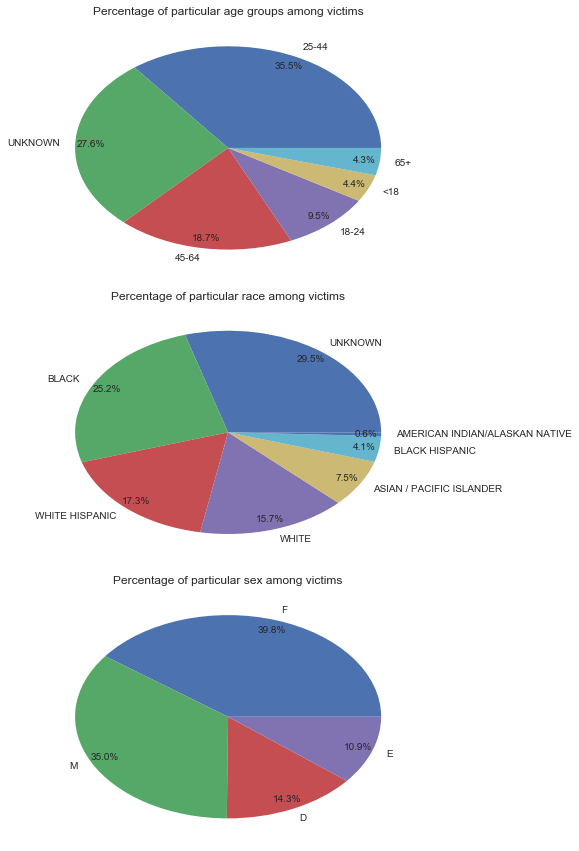

In [97]:
#victims pie plots

data_vic_1 = df['vic_age_group'].value_counts(normalize=True)
data_vic_2 = df['vic_race'].value_counts(normalize=True)
data_vic_3 = df['vic_sex'].value_counts(normalize=True)

plt.style.use("fast")
fig, axis = plt.subplots(3, 1, figsize=(6,12))
plt.tight_layout()

axis[0].pie(data_vic_1, autopct='%1.1f%%', pctdistance=0.9, labels=data_vic_1.index)
axis[0].set_title('Percentage of particular age groups among victims')

axis[1].pie(data_vic_2, autopct='%1.1f%%', pctdistance=0.9, labels=data_vic_2.index)
axis[1].set_title('Percentage of particular race among victims')


axis[2].pie(data_vic_3, autopct='%1.1f%%', pctdistance=0.9, labels=data_vic_3.index)
axis[2].set_title('Percentage of particular sex among victims')


plt.show()

In [98]:
#rodzaj przestępswta w zależności od poszkodowanego 
#rodzaj przestępswta w zależności od płci, jaka płeć jakie atak na nią był, grupowania 
#jakich przestępst się jakie wieki dopuściły

In [99]:
#'ofns_level',  'ofns_desc'64, 'detail_ofns_desc'355, 'case_solved', 'parks_nm'
df['ofns_level'].value_counts()

MISDEMEANOR    245466
FELONY         141881
VIOLATION       72406
Name: ofns_level, dtype: int64

In [100]:
group_district_ofns_desc = df.groupby(['district', 'ofns_level'])['police_precincts'].count()

In [101]:
group_district_ofns_desc

district       ofns_level 
BRONX          FELONY         28325
               MISDEMEANOR    55472
               VIOLATION      16965
BROOKLYN       FELONY         43741
               MISDEMEANOR    67666
               VIOLATION      20695
MANHATTAN      FELONY         36015
               MISDEMEANOR    64403
               VIOLATION      15181
QUEENS         FELONY         29132
               MISDEMEANOR    47724
               VIOLATION      15476
STATEN ISLAND  FELONY          4668
               MISDEMEANOR    10201
               VIOLATION       4089
Name: police_precincts, dtype: int64